# Definitions
_acris_ (l.): sharp, bitter, pointed, piercing, shrill.

https://latin-dictionary.net/definition/489/acer-acris#:~:text=sharp%2C%20bitter%2C%20pointed%2C%20piercing%2C%20shrill

## Data dictionary

https://github.com/nycdb/nycdb/wiki/Dataset:-ACRIS

## Process

We will follow the data thinking workflow: 

1. First use the Jupyter notebook `%%sql` cell magic command to parse the entiretiy of the comma-separated value file using a `SELECT *` statement.
2. Then we will specify data types for every field needed.
3. Then we will add `ENUM`s to properly enumerate the data dictionary references.
4. Then we will reach out to a human incentizied to help us understand whether we have made the correct decisions in type inference of the preceding Steps 1–3.
5. If time, we will file bugs for any open source issues we believe can be readily reproduced and will compound into technical debt or user experience regression down the line, if we were to rely on the above infrastructure in the future.

We will use large language models throughout this exercise to write as little code as possible. On airplanes or without wireless internet, we will use ethernet cables or local large language models to help us (though a Visual Studio Code plugin for WizardCoder or other coding-specific LLMs that run with MLX may not be available yet).

On airgapped systems or airplanes we will download documentation a priori: 

* https://duckdb.org/duckdb-docs.pdf 

This will also be helpful to feed to the large language models :)

# Data

Go to the NYC Open Data website for the Department of Finance Real Property Master file:
* https://data.cityofnewyork.us/City-Government/ACRIS-Real-Property-Master/bnx9-e6tj/about_data
* Hit F12 in Chrome/Firefox to open the developer console and click on `Network` tab.
* Click on `Export` and then `CSV` to download the data. 
* if that doesn't download, then, look for the request that starts with: `GET /api/views/bnx9-e6tj/rows.csv?fourfour=bnx9-e6tj&cacheBust=1712779181&date=20240422&accessType=DOWNLOAD HTTP/1.1`
* right click, copy the URL, and paste it here.

(thanks to Chloé Marcel for the tip via https://beta.nyc Slack :)

In [1]:
!wget "https://data.cityofnewyork.us/api/views/bnx9-e6tj/rows.csv?fourfour=bnx9-e6tj&cacheBust=1712779181&date=20240422&accessType=DOWNLOAD"

--2024-04-22 08:48:05--  https://data.cityofnewyork.us/api/views/bnx9-e6tj/rows.csv?fourfour=bnx9-e6tj&cacheBust=1712779181&date=20240422&accessType=DOWNLOAD
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.140.205, 52.206.68.26, 52.206.140.199
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?fourfour=bnx9-e6tj&cacheBust=1712779181&date=20240422&accessType=DOWNLOAD.2’

rows.csv?fourfour=b     [        <=>         ] 693.54M  1.45MB/s    in 6m 39s  


Cannot write to ‘rows.csv?fourfour=bnx9-e6tj&cacheBust=1712779181&date=20240422&accessType=DOWNLOAD.2’ (Success).


In [3]:
path = "~/Downloads/ACRIS_-_Real_Property_Master_20240422.csv"

## Try displaying a little bit of the data

In [1]:
# Load duckdb, which lets us efficiently load large files
import duckdb

# Load pandas, which lets us manipulate dataframes
import pandas as pd

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

# Set configrations on jupysql to directly output data to Pandas and to simplify the output that is printed to the notebook.
%config SqlMagic.autopandas = True

%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Allow named parameters (python variables) in SQL cells
%config SqlMagic.named_parameters=True

# Connect jupysql to DuckDB using a SQLAlchemy-style connection string. Either connect to an in memory DuckDB, or a file backed db.
%sql duckdb:///:memory:

Deploy Dash apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


/Users/me/projects/new-york-real-estate/.venv/lib/python3.10/site-packages/sql/traits.py:20: FutureWarning: named_parameters: boolean values are now deprecated. Value True will be treated as "enabled". 
Please use a valid option: "warn", "enabled", or "disabled". 
For more information, see the docs: https://jupysql.ploomber.io/en/latest/api/configuration.html#named-parameters
  warnings.warn(


In [10]:
!head ~/Downloads/ACRIS_-_Real_Property_Master_20240422.csv

DOCUMENT ID,RECORD TYPE,CRFN,BOROUGH,DOC. TYPE,DOC. DATE,DOC. AMOUNT,RECORDED / FILED,MODIFIED DATE,REEL YEAR,REEL NBR,REEL PAGE,% TRANSFERRED,GOOD THROUGH DATE
2017010501405001,A,2017000012454,1,SAT,10/27/2016,0,01/10/2017,01/10/2017,0,0,0,0,01/31/2017
2017011101293006,A,2017000018380,1,TL&R,01/10/2017,0,01/12/2017,01/12/2017,0,0,0,0,01/31/2017
2017012300585021,A,2017000029436,1,PAT,09/27/2016,0,01/23/2017,01/23/2017,0,0,0,0,01/31/2017
2017011801183001,A,2017000026509,1,MTGE,12/27/2016,12521.78,01/19/2017,01/19/2017,0,0,0,0,01/31/2017
2017010901191102,A,2017000029668,1,EASE,12/28/2016,0,01/23/2017,01/23/2017,0,0,0,100,01/31/2017
2017012800045009,A,2017000040867,1,RPTT&RET,12/31/2016,0,01/30/2017,01/30/2017,0,0,0,100,01/31/2017
2017010400104002,A,2017000004243,1,ASST,12/07/2016,0,01/04/2017,01/04/2017,0,0,0,0,01/31/2017
2016122200494001,A,2017000002407,4,SAT,12/21/2016,0,01/04/2017,01/04/2017,0,0,0,0,01/31/2017
2016122800065001,A,2017000009755,1,MTGE,12/17/2016,187000,01/09/2017,01/09/

In [8]:
%%sql 

SELECT * FROM '~/Downloads/ACRIS_-_Real_Property_Master_20240422.csv'

ConversionException: Conversion Error: CSV Error on Line: 4236644
Error when converting column "DOC. DATE".

Column DOC. DATE is being converted as type DATE
This type was auto-detected from the CSV file.
Possible solutions:
* Override the type for this column manually by setting the type explicitly, e.g. types={'DOC. DATE': 'VARCHAR'}
* Set the sample size to a larger value to enable the auto-detection to scan more values, e.g. sample_size=-1
* Use a COPY statement to automatically derive types from an existing table.
  file=/Users/me/Downloads/ACRIS_-_Real_Property_Master_20240422.csv
  delimiter = , (Auto-Detected)
  quote = " (Auto-Detected)
  escape = " (Auto-Detected)
  new_line = \n (Auto-Detected)
  header = true (Auto-Detected)
  skip_rows = 0 (Auto-Detected)
  date_format = %m/%d/%Y (Auto-Detected)
  timestamp_format =  (Auto-Detected)
  null_padding=0
  sample_size=20480
  ignore_errors=0
  all_varchar=0


In [17]:
%%sql 

SELECT * FROM read_csv_auto('~/Downloads/ACRIS_-_Real_Property_Master_20240422.csv',
                            types={'DOC. DATE': 'VARCHAR'},
                            dateformat='%m/%d/%Y')

,DOCUMENT ID,RECORD TYPE,CRFN,BOROUGH,DOC. TYPE,DOC. DATE,DOC. AMOUNT,RECORDED / FILED,MODIFIED DATE,REEL YEAR,REEL NBR,REEL PAGE,% TRANSFERRED,GOOD THROUGH DATE
0,2017010501405001,A,2.017000e+12,1,SAT,10/27/2016,0.00,2017-01-10,2017-01-10,0,0,0,0.0,2017-01-31
1,2017011101293006,A,2.017000e+12,1,TL&R,01/10/2017,0.00,2017-01-12,2017-01-12,0,0,0,0.0,2017-01-31
2,2017012300585021,A,2.017000e+12,1,PAT,09/27/2016,0.00,2017-01-23,2017-01-23,0,0,0,0.0,2017-01-31
3,2017011801183001,A,2.017000e+12,1,MTGE,12/27/2016,12521.78,2017-01-19,2017-01-19,0,0,0,0.0,2017-01-31
4,2017010901191102,A,2.017000e+12,1,EASE,12/28/2016,0.00,2017-01-23,2017-01-23,0,0,0,100.0,2017-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16377161,2024030100415001,A,2.024000e+12,3,RPTT&RET,02/12/2024,0.00,2024-03-13,2024-03-13,0,0,0,100.0,2024-03-31
16377162,2024030100473001,A,2.024000e+12,1,DEED,02/23/2024,0.00,2024-03-01,2024-03-01,0,0,0,100.0,2024-03-31
16377163,2024032100121001,A,2.024000e+12,4,DEED,03/12/2024,2000000.00,2024-03-26,2024-03-26,0,0,0,100.0,2024-03-31
16377164,2024031200815001,A,2.024000e+12,1,DEED,11/21/2023,0.00,2024-03-13,2024-03-13,0,0,0,100.0,2024-03-31


# Create a new dbt data model using the DuckDB SQL dialect

Do this in `~/data_processing/models/cityofnewyork.us/dof_acris_real_property_master.sql`

Then run `dbt run --select "*dof*"` to materialize the model in a parquet file.

Then we can view the model.

# Exploratory data analysis

In [18]:
!duckdb -c "SELECT * FROM '~/data/dof_acris_real_property_master.parquet'"

┌──────────────────┬─────────────┬───┬───────────────┬───────────────────┐
│   DOCUMENT ID    │ RECORD TYPE │ … │ % TRANSFERRED │ GOOD THROUGH DATE │
│     varchar      │   varchar   │   │    double     │       date        │
├──────────────────┼─────────────┼───┼───────────────┼───────────────────┤
│ 2017010501405001 │ A           │ … │           0.0 │ 2017-01-31        │
│ 2017011101293006 │ A           │ … │           0.0 │ 2017-01-31        │
│ 2017012300585021 │ A           │ … │           0.0 │ 2017-01-31        │
│ 2017011801183001 │ A           │ … │           0.0 │ 2017-01-31        │
│ 2017010901191102 │ A           │ … │         100.0 │ 2017-01-31        │
│ 2017012800045009 │ A           │ … │         100.0 │ 2017-01-31        │
│ 2017010400104002 │ A           │ … │           0.0 │ 2017-01-31        │
│ 2016122200494001 │ A           │ … │           0.0 │ 2017-01-31        │
│ 2016122800065001 │ A           │ … │           0.0 │ 2017-01-31        │
│ 2017013000950001 │ A   

In [19]:
%%sql 

SELECT * FROM '~/data/dof_acris_real_property_master.parquet'

,DOCUMENT ID,RECORD TYPE,CRFN,BOROUGH,DOC. TYPE,DOC. DATE,DOC. AMOUNT,RECORDED / FILED,MODIFIED DATE,REEL YEAR,REEL NBR,REEL PAGE,% TRANSFERRED,GOOD THROUGH DATE
0,2017010501405001,A,2.017000e+12,1,SAT,10/27/2016,0.00,2017-01-10,2017-01-10,0,0,0,0.0,2017-01-31
1,2017011101293006,A,2.017000e+12,1,TL&R,01/10/2017,0.00,2017-01-12,2017-01-12,0,0,0,0.0,2017-01-31
2,2017012300585021,A,2.017000e+12,1,PAT,09/27/2016,0.00,2017-01-23,2017-01-23,0,0,0,0.0,2017-01-31
3,2017011801183001,A,2.017000e+12,1,MTGE,12/27/2016,12521.78,2017-01-19,2017-01-19,0,0,0,0.0,2017-01-31
4,2017010901191102,A,2.017000e+12,1,EASE,12/28/2016,0.00,2017-01-23,2017-01-23,0,0,0,100.0,2017-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16377161,2024030100415001,A,2.024000e+12,3,RPTT&RET,02/12/2024,0.00,2024-03-13,2024-03-13,0,0,0,100.0,2024-03-31
16377162,2024030100473001,A,2.024000e+12,1,DEED,02/23/2024,0.00,2024-03-01,2024-03-01,0,0,0,100.0,2024-03-31
16377163,2024032100121001,A,2.024000e+12,4,DEED,03/12/2024,2000000.00,2024-03-26,2024-03-26,0,0,0,100.0,2024-03-31
16377164,2024031200815001,A,2.024000e+12,1,DEED,11/21/2023,0.00,2024-03-13,2024-03-13,0,0,0,100.0,2024-03-31


In [5]:
df = pd.read_parquet('~/data/dof_acris_real_property_master.parquet')

In [6]:
df.columns

Index(['DOCUMENT ID', 'RECORD TYPE', 'CRFN', 'BOROUGH', 'DOC. TYPE',
       'DOC. DATE', 'DOC. AMOUNT', 'RECORDED / FILED', 'MODIFIED DATE',
       'REEL YEAR', 'REEL NBR', 'REEL PAGE', '% TRANSFERRED',
       'GOOD THROUGH DATE'],
      dtype='object')

<Axes: >

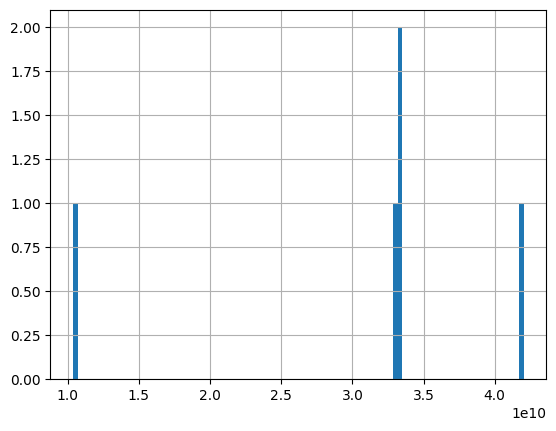

In [7]:
df[df['DOC. AMOUNT'] > 10000000000]['DOC. AMOUNT'].hist(bins=100)

In [8]:
df[df['DOC. AMOUNT'] > 10000000000]

,DOCUMENT ID,RECORD TYPE,CRFN,BOROUGH,DOC. TYPE,DOC. DATE,DOC. AMOUNT,RECORDED / FILED,MODIFIED DATE,REEL YEAR,REEL NBR,REEL PAGE,% TRANSFERRED,GOOD THROUGH DATE
211148,2017062900338004,A,2.017000e+12,1,AL&R,06/29/2017,4.205500e+10,2017-07-06,2017-07-06,0,0,0,0.0,2017-07-31
4551876,2009081000139003,A,2.009000e+12,4,MTGE,07/09/2009,3.330000e+10,2009-08-21,2009-08-21,0,0,0,0.0,2015-07-31
15410556,2009081000228003,A,2.009000e+12,1,MTGE,07/09/2009,3.330000e+10,2009-08-17,2009-08-17,0,0,0,0.0,2015-07-31
15887013,2016121500457003,A,2.016000e+12,1,AGMT,12/09/2016,3.300000e+10,2016-12-19,2016-12-19,0,0,0,0.0,2016-12-31
16178188,2023062400018001,A,2.023000e+12,1,AGMT,06/05/2023,1.036816e+10,2023-07-05,2023-07-05,0,0,0,0.0,2023-07-31


# Real Property Parties

So many fun events are happening related to new york city events, and we can use this data to help us plan related parties and associated festivities :)

Source: 

https://data.cityofnewyork.us/City-Government/ACRIS-Real-Property-Parties/636b-3b5g/about_data

In [3]:
!wget "https://data.cityofnewyork.us/api/views/636b-3b5g/rows.csv?accessType=DOWNLOAD" -O ~/data/dof_acris_real_property_parties.csv

--2024-04-29 17:34:05--  https://data.cityofnewyork.us/api/views/636b-3b5g/rows.csv?accessType=DOWNLOAD
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.68.26, 52.206.140.205, 52.206.140.199
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD.3’

rows.csv?accessType     [             <=>    ]   4.01G  4.93MB/s    in 16m 52s 

2024-04-29 17:50:57 (4.05 MB/s) - ‘rows.csv?accessType=DOWNLOAD.3’ saved [4301658835]



In [4]:
!mv rows.csv?accessType=DOWNLOAD ~/data/rows.csv

In [5]:
!head ~/data/rows.csv

DOCUMENT ID,RECORD TYPE,PARTY TYPE,NAME,ADDRESS 1,ADDRESS 2,COUNTRY,CITY,STATE,ZIP,GOOD THROUGH DATE
2018073000132001,P,1,"TAYLOR, EMILY","360 FURMAN STREET, UNIT 933",,US,BROOKLYN,NY,11201,08/31/2018 12:00:00 AM
2018082900859001,P,2,QUICKEN LOANS INC.,1050 WOODWARD AVE,,US,DETROIT,MI,48226,08/31/2018 12:00:00 AM
2018081600002001,P,2,"MORTGAGE ELECTRONIC REGISTRATION SYSTEMS, INC",,,,,,,08/31/2018 12:00:00 AM
2018081701275001,P,1,"KIM, NANCY","6210 WOODSIDE AVE, APT 211",,US,WOODSIDE,NY,11377,08/31/2018 12:00:00 AM
2018082701133001,P,1,LAWRENCE SKEETE,198 LEFFERTS PLACE,,US,BROOKLYN,NY,11238,08/31/2018 12:00:00 AM
2018081600597003,P,2,HABITAT QUEENS PHASE II HOUSING DEVELOPMENT CORP,111 JOHN STREET - 23RD FLOOR,,US,NEW YORK,NY,10038,08/31/2018 12:00:00 AM
2018081700353004,P,2,"JUBA, AMY LANDESS","6355 METROWEST BOULEVARD, SUITE 180",,US,ORLANDO,FL,32835,08/31/2018 12:00:00 AM
2018081100034001,P,1,"FORRESTER, JESSICA","80 WINTHROP STREET, APT L1",,US,BROOKLYN,NY,11225,08/31/2018 12:00:0

## Debugging SQL for real property parties from nyc open data portal

In [6]:
%%sql

SELECT
    "DOCUMENT ID"::VARCHAR AS document_id,
    "RECORD TYPE"::VARCHAR AS record_type,
    "PARTY TYPE"::INTEGER AS party_type,
    "NAME"::VARCHAR AS name,
    "ADDRESS 1"::VARCHAR AS address_1,
    "ADDRESS 2"::VARCHAR AS address_2,
    "COUNTRY"::VARCHAR AS country,
    "CITY"::VARCHAR AS city,
    "STATE"::VARCHAR AS state,
    "ZIP"::VARCHAR AS zip,
    "GOOD THROUGH DATE"::TIMESTAMP AS good_through_date
FROM read_csv_auto('~/data/rows.csv', header=True, sep=',');

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,document_id,record_type,party_type,name,address_1,address_2,country,city,state,zip,good_through_date
0,2018073000132001,P,1,"TAYLOR, EMILY","360 FURMAN STREET, UNIT 933",None,US,BROOKLYN,NY,11201,2018-08-31
1,2018082900859001,P,2,QUICKEN LOANS INC.,1050 WOODWARD AVE,None,US,DETROIT,MI,48226,2018-08-31
2,2018081600002001,P,2,"MORTGAGE ELECTRONIC REGISTRATION SYSTEMS, INC",None,None,None,None,None,None,2018-08-31
3,2018081701275001,P,1,"KIM, NANCY","6210 WOODSIDE AVE, APT 211",None,US,WOODSIDE,NY,11377,2018-08-31
4,2018082701133001,P,1,LAWRENCE SKEETE,198 LEFFERTS PLACE,None,US,BROOKLYN,NY,11238,2018-08-31
...,...,...,...,...,...,...,...,...,...,...,...
44513087,2024031500368001,P,2,TD BANK NA,2035 LIMESTONE RD,None,US,WILMINGTON,DE,19808,2024-03-31
44513088,2024031700026001,P,2,"WILLIAMS, CHRISTOPHER",3215 BRUNER AVENUE,None,US,BRONX,NY,10469,2024-03-31
44513089,2024032200063001,P,1,STATES CAPITAL LLC,"88-10 136TH STREET, SUITE 1",None,US,RICHMOND HILL,NY,11418,2024-03-31
44513090,2024032100719001,P,1,"MARINE COOPERATIVE APTS., INC.",2239 TROY AVENUE,None,US,BROOKLYN,NY,11234,2024-03-31


# Try downloading from GitHub direct link

https://github.com/nycdb/nycdb/blob/main/src/nycdb/datasets/acris.yml lists another direct link to try...

In [1]:
!wget "https://data.cityofnewyork.us/api/views/636b-3b5g/rows.csv?accessType=DOWNLOAD"

--2024-05-04 13:49:16--  https://data.cityofnewyork.us/api/views/636b-3b5g/rows.csv?accessType=DOWNLOAD
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.140.199, 52.206.140.205, 52.206.68.26
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [   <=>              ]   4.01G  2.73MB/s    in 17m 35s 

2024-05-04 14:06:51 (3.89 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [4301658835]



In [2]:
!wc -l rows.csv?accessType=DOWNLOAD

 44513093 rows.csv?accessType=DOWNLOAD


In [4]:
!mv rows.csv?accessType=DOWNLOAD ~/data/rows.csv

In [ ]:
%%sql 

# Try downloading via API link from beta.nyc

Thanks to Zachary for pointing this out! https://dev.socrata.com/foundry/data.cityofnewyork.us/636b-3b5g

In [3]:
!wget "https://data.cityofnewyork.us/api/views/636b-3b5g/rows.csv?accessType=DOWNLOAD&api_foundry=true"

--2024-04-25 08:13:50--  https://data.cityofnewyork.us/api/views/636b-3b5g/rows.csv?accessType=DOWNLOAD&api_foundry=true
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.140.205, 52.206.140.199, 52.206.68.26
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD&api_foundry=true’

rows.csv?accessType     [          <=>       ] 196.27M   188KB/s    in 13m 27s 

2024-04-25 08:27:18 (249 KB/s) - ‘rows.csv?accessType=DOWNLOAD&api_foundry=true’ saved [205799495]



# Data Dictionary

From https://catalog.data.gov/dataset/acris-document-control-codes

In [2]:
!wget "https://data.cityofnewyork.us/api/views/7isb-wh4c/rows.csv?accessType=DOWNLOAD"

--2024-04-29 17:33:33--  https://data.cityofnewyork.us/api/views/7isb-wh4c/rows.csv?accessType=DOWNLOAD
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.68.26, 52.206.140.205, 52.206.140.199
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD.2’

rows.csv?accessType     [ <=>                ]   9.03K  --.-KB/s    in 0s      

2024-04-29 17:33:33 (2.15 GB/s) - ‘rows.csv?accessType=DOWNLOAD.2’ saved [9251]



In [3]:
!mv rows.csv\?accessType\=DOWNLOAD dof_acris_control_codes.csv

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/me/projects/new-york-real-estate/.venv/lib/python3.12/site-packages/IPython/core/extensions.py", line 62, in load_extension
  File "/Users/me/projects/new-york-real-estate/.venv/lib/python3.12/site-packages/IPython/core/extensions.py", line 77, in _load_extension
  File "/usr/local/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/importlib/__init__.py", line 90, in import_module
  File "<frozen importlib._bootstrap>", line 1387, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1324, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'autoreload'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/me/projects/new-york-real-estate/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/var/folders/2c/h